In [162]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import sklearn
from scipy.stats import chi2_contingency
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, OneHotEncoder, LabelBinarizer
from sklearn.preprocessing import PolynomialFeatures, MinMaxScaler, StandardScaler
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split,GridSearchCV,RandomizedSearchCV,learning_curve
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.feature_selection import SelectKBest, f_regression, chi2 , f_classif, VarianceThreshold
from sklearn import set_config
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, precision_recall_curve, confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from imblearn.over_sampling import SMOTE

from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, adjusted_rand_score

In [3]:
data = pd.read_csv("sobar-72.csv")

In [4]:
data.drop(labels="ca_cervix",axis=1, inplace=True)

In [131]:
data.shape

(72, 19)

In [130]:
data.columns

Index(['behavior_sexualRisk', 'behavior_eating', 'behavior_personalHygine',
       'intention_aggregation', 'intention_commitment', 'attitude_consistency',
       'attitude_spontaneity', 'norm_significantPerson', 'norm_fulfillment',
       'perception_vulnerability', 'perception_severity',
       'motivation_strength', 'motivation_willingness',
       'socialSupport_emotionality', 'socialSupport_appreciation',
       'socialSupport_instrumental', 'empowerment_knowledge',
       'empowerment_abilities', 'empowerment_desires'],
      dtype='object')

In [ ]:
df = data.copy()


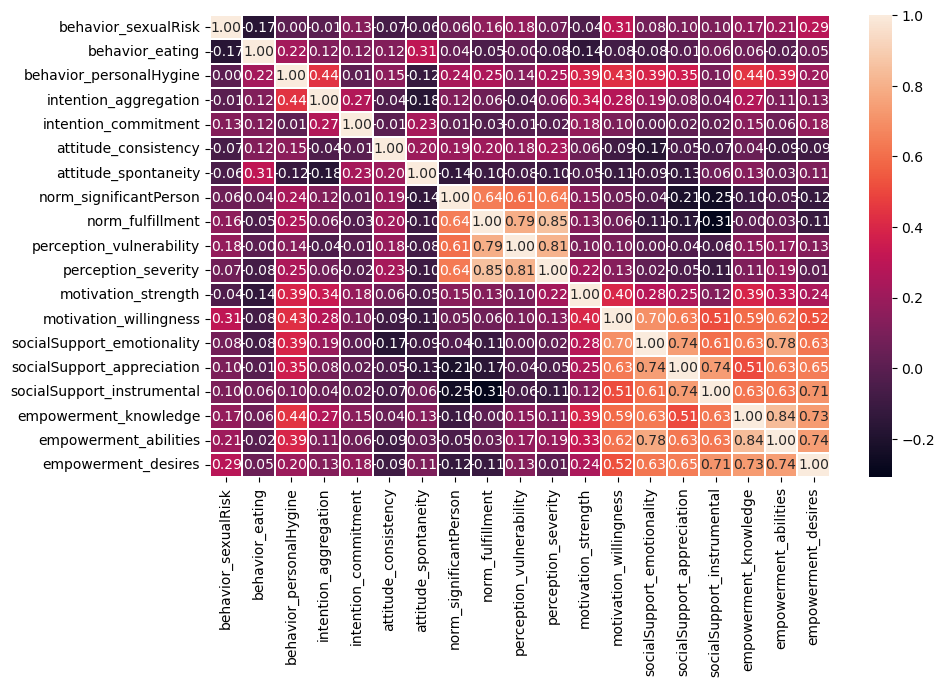

In [6]:
corr = df.corr(method = 'pearson')
plt.figure(figsize=(10,6)) # dpi =500 augmente la taille de l'image 
sns.heatmap(corr,annot=True,fmt=".2f", linewidth=.2)
plt.show()

PCA

In [7]:
scaler = StandardScaler()
X_scaler = scaler.fit_transform(df)

In [8]:
df_bis = pd.DataFrame(X_scaler)

In [9]:
n_components = 7

In [10]:
pca = PCA(n_components=n_components)

In [11]:
pca.fit(X_scaler)

PCA(n_components=7)

In [12]:
(pca.explained_variance_ratio_*100).round(2)

array([28.71, 18.61,  8.85,  8.27,  6.59,  5.06,  4.39])

In [13]:
scree = (pca.explained_variance_ratio_*100).round(2)
scree.cumsum().round(2)

array([28.71, 47.32, 56.17, 64.44, 71.03, 76.09, 80.48])

In [14]:
x_list = range(1, n_components+1)
list(x_list)

[1, 2, 3, 4, 5, 6, 7]

In [15]:
scree_cum = scree.cumsum().round(2)
scree_cum

array([28.71, 47.32, 56.17, 64.44, 71.03, 76.09, 80.48])

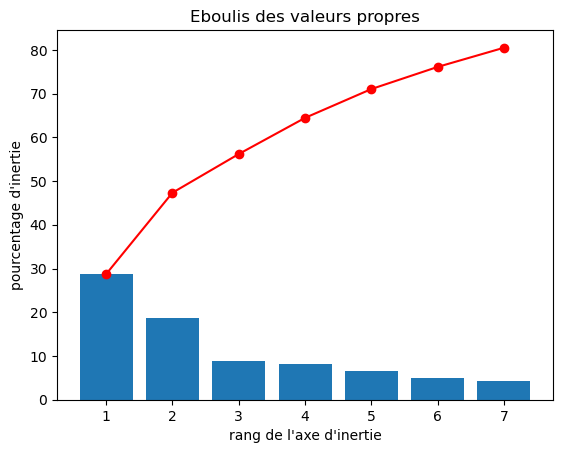

In [ ]:
plt.bar(x_list, scree)
plt.plot(x_list, scree_cum, c="red", marker='o')
plt.xlabel("rang de l'axe d'inertie")
plt.ylabel("pourcentage d'inertie")
plt.title("Eboulis des valeurs propres")
plt.show(block=False)

In [ ]:
pcs = pd.DataFrame(pca.components_, columns=df.columns)
pcs.index = [f"F{i}" for i in range(1, n_components + 1)]
pcs.round(2)

<Axes: >

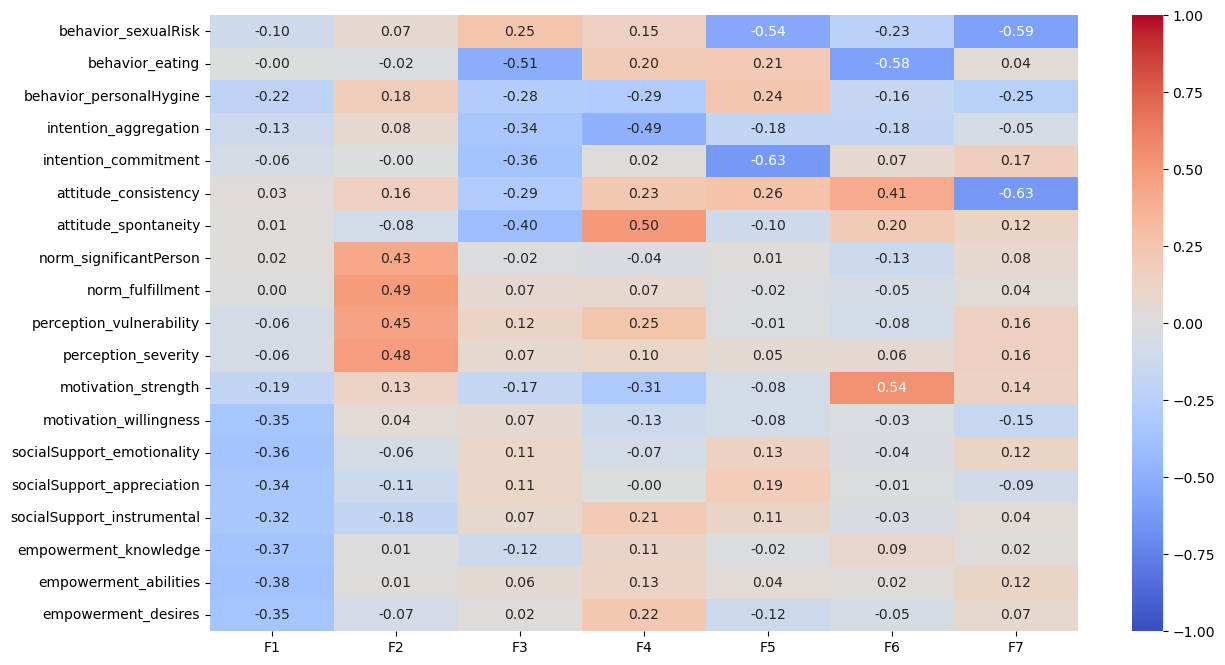

In [61]:
pcs.T
fig, ax = plt.subplots(figsize=(14,8))
sns.heatmap(pcs.T, vmin=-1, vmax=1, annot=True, cmap="coolwarm", fmt="0.2f")

In [47]:
x, y = 0,2

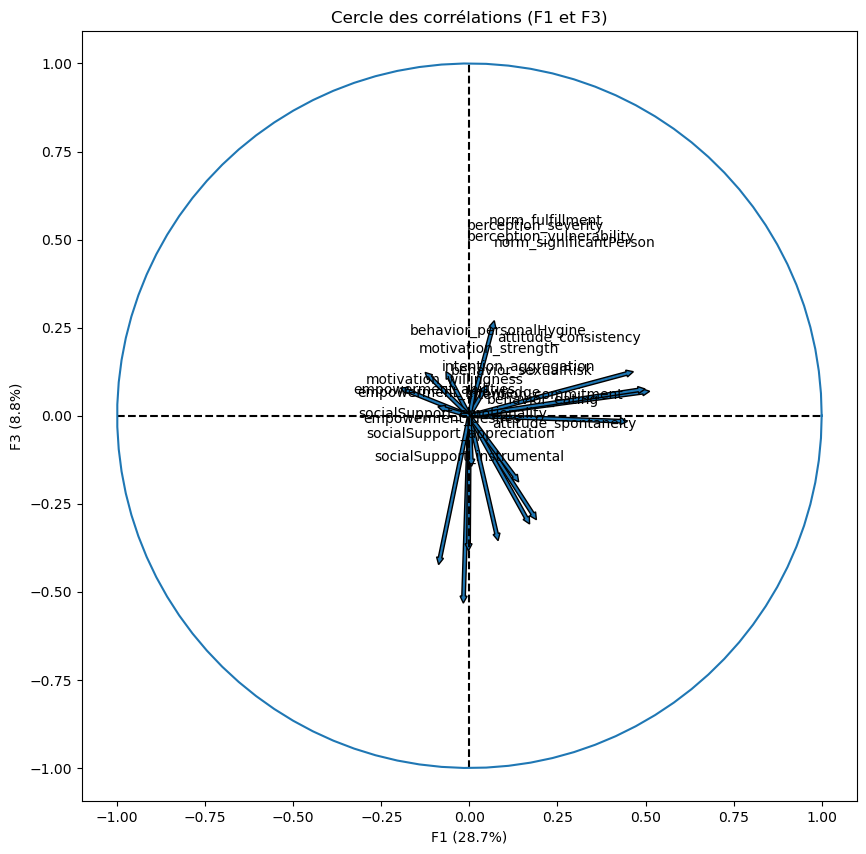

In [62]:
fig, ax = plt.subplots(figsize=(10, 10))
for i in range(0, pca.components_.shape[1]):
    ax.arrow(0,
             0,  # Start the arrow at the origin
             pca.components_[1, i],  #0 for PC1
             pca.components_[2, i],  #1 for PC2
             head_width=0.02,
             head_length=0.02, 
             width=0.01,              )

    plt.text(pca.components_[0, i] + 0.05,
             pca.components_[1, i] + 0.05,
             df.columns [i])
    
# affichage des lignes horizontales et verticales
plt.plot([-1, 1], [0, 0], color='black', ls='--')
plt.plot([0, 0], [-1, 1], color='black', ls='--')


# nom des axes, avec le pourcentage d'inertie expliqué
plt.xlabel('F{} ({}%)'.format(x+1, round(100*pca.explained_variance_ratio_[x],1)))
plt.ylabel('F{} ({}%)'.format(y+1, round(100*pca.explained_variance_ratio_[y],1)))

plt.title("Cercle des corrélations (F{} et F{})".format(x+1, y+1))


an = np.linspace(0, 2 * np.pi, 100)
plt.plot(np.cos(an), np.sin(an))  # Add a unit circle for scale
plt.axis('equal')
plt.show(block=False)

In [23]:
Y = df.values

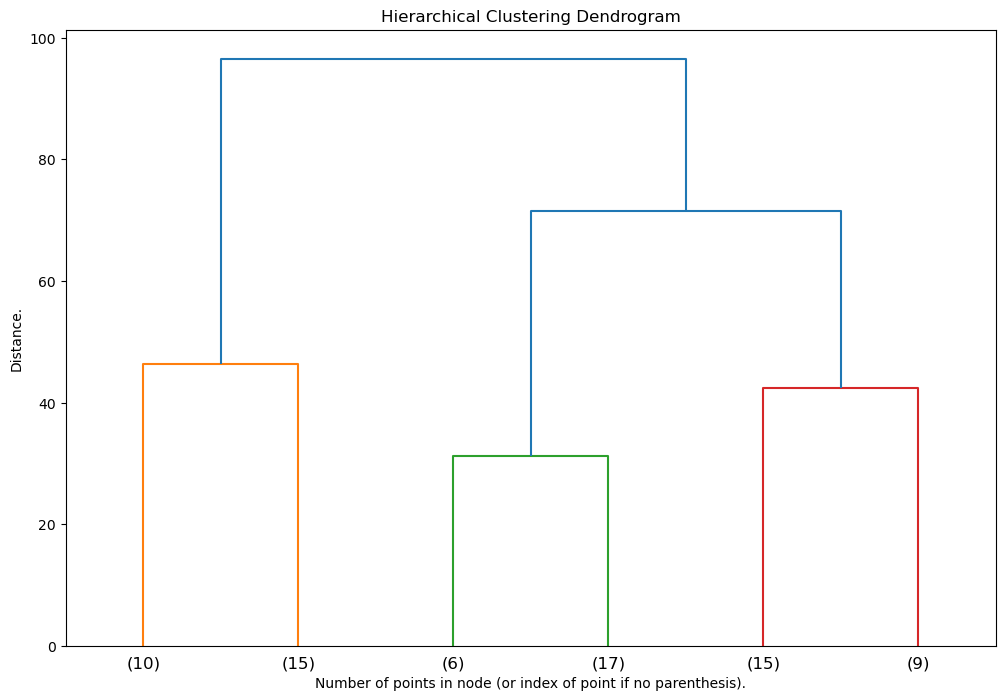

In [24]:
w = linkage(Y, method="ward")
fig, ax = plt.subplots(1, 1, figsize=(12, 8))

dendrogram(w, p=6, truncate_mode="lastp", ax=ax)

plt.title("Hierarchical Clustering Dendrogram")
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.ylabel("Distance.")
plt.show()

Kmeans 

In [68]:

# Stocker les valeurs transformées de PCA
X_proj = pca.transform(X_scaler)
X_df = pd.DataFrame(X_proj, columns=[f'F{i+1}' for i in range(n_components)])

In [177]:
X=X_scaler
# Une liste vide pour enregistrer les inerties :  
intertia_list = [ ]

silhouette = []
# Notre liste de nombres de clusters : 
k_list = range(2, 8)

# Pour chaque nombre de clusters : 
for k in k_list : 
    
    # On instancie un k-means pour k clusters
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    
    # On entraine
    kmeans.fit(X)
    
    # On enregistre l'inertie obtenue : 
    intertia_list.append(kmeans.inertia_)
    silhouette.append(silhouette_score(X_scaler, kmeans.labels_))

c:\Users\ibrah\anaconda3\anaconda4\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\ibrah\anaconda3\anaconda4\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\ibrah\anaconda3\anaconda4\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\ibrah\anaconda3\anaconda4\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans 

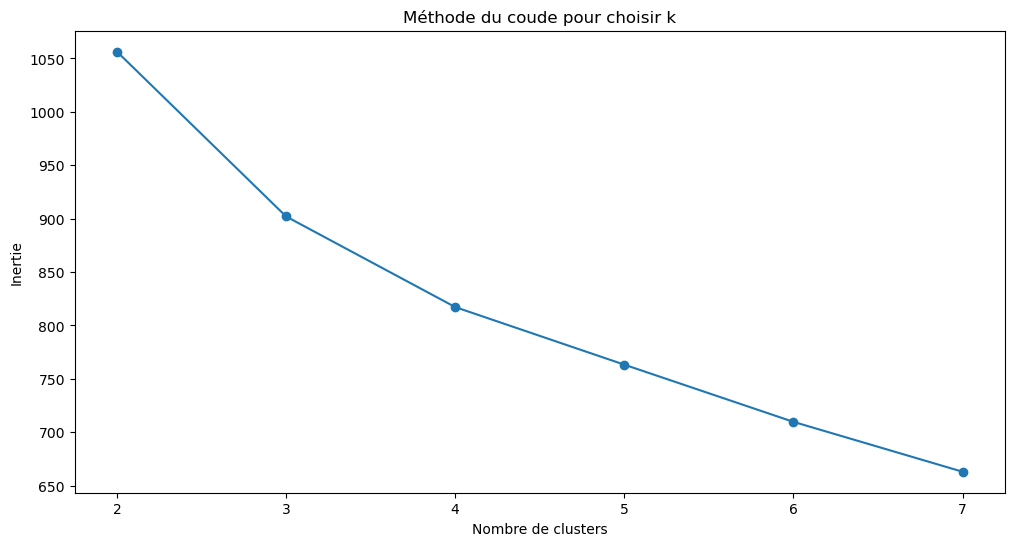

In [178]:
# Affichage de la courbe d'inertie
plt.figure(figsize=(12, 6))
plt.plot(k_list, intertia_list, marker='o')
plt.xlabel("Nombre de clusters")
plt.ylabel("Inertie")
plt.title("Méthode du coude pour choisir k")
plt.show()

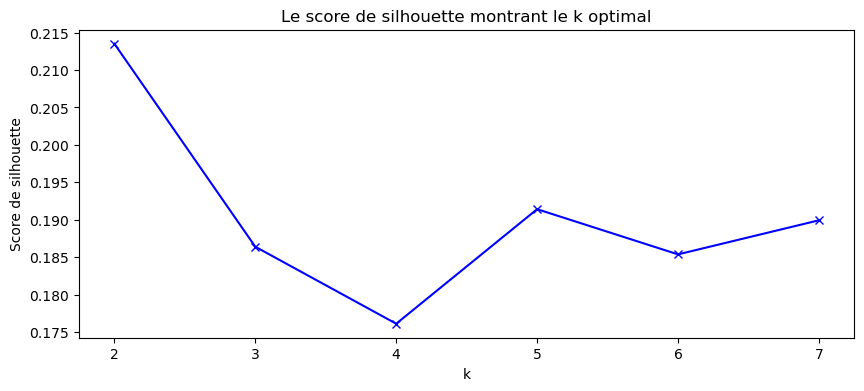

In [179]:

# Graphique du score de silhouette
plt.figure(figsize=(10,4))
plt.plot(k_list, silhouette, 'bx-')
plt.xlabel('k')
plt.ylabel('Score de silhouette')
plt.title('Le score de silhouette montrant le k optimal')
plt.show()

In [169]:
kmeans = KMeans(n_clusters=3, random_state=42,n_init=10 )
kmeans.fit(X)
X_df["cluster"] = kmeans.labels_

c:\Users\ibrah\anaconda3\anaconda4\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


In [170]:
centroids = kmeans.cluster_centers_
# centroids_x = centroids[:,0]
# centroids_y = centroids[:,1]

centroids_proj = pca.transform(centroids)

In [171]:
dd = {i:j for i,j in enumerate(list("ABC"))}
labels = [dd[i] for i in kmeans.labels_]

In [172]:
X_df["cluster"] = labels
X_df

,F1,F2,F3,F4,F5,F6,F7,cluster
0,0.342592,-0.936635,0.446282,1.250426,2.136535,1.044377,-1.491137,B
1,1.529634,-0.265882,0.171090,-2.674850,-0.734112,0.274357,-0.883843,A
2,3.062307,-2.569781,0.483013,3.169881,-0.385088,-0.330291,-0.145830,A
3,1.935554,-1.143931,0.079052,-2.561227,-1.251638,0.640895,-0.850740,A
4,2.429305,-2.124489,0.607173,-1.059057,1.124354,1.335558,0.371443,A
...,...,...,...,...,...,...,...,...
67,-1.563514,2.534330,0.035964,-0.941924,-0.352854,-0.950778,0.593843,C
68,-2.231898,2.266259,-0.168022,-0.030768,-0.270392,-0.405829,-0.343736,C
69,-0.623423,0.988907,3.467877,-1.706384,0.585039,0.467336,-0.159730,C
70,-1.887889,2.076990,1.113563,-1.030141,0.453345,-0.798237,1.038818,C


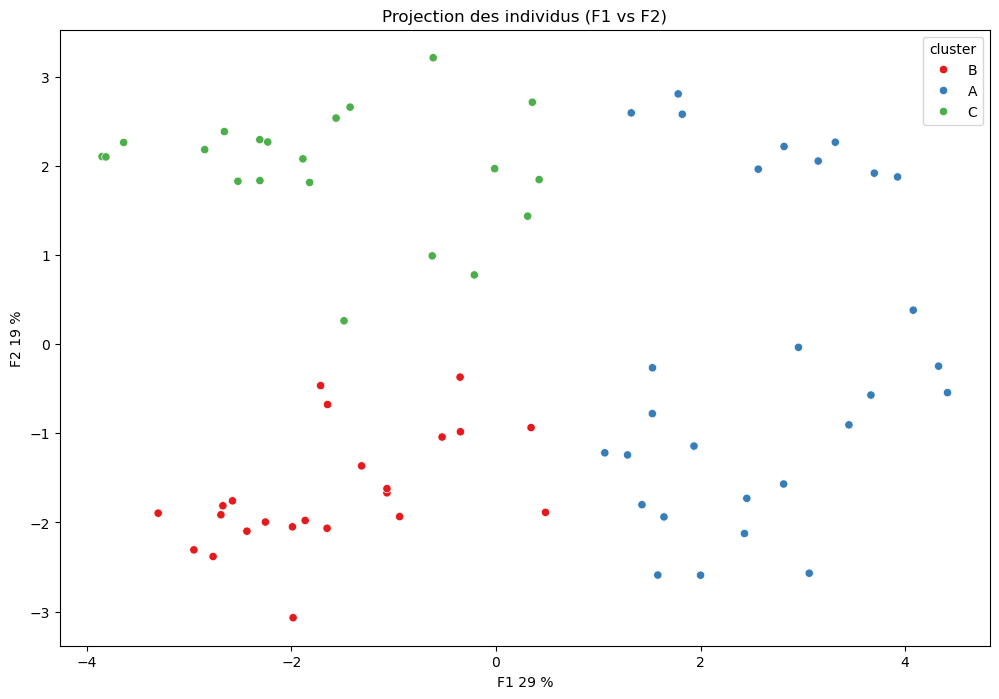

In [173]:
# Fonction de visualisation
def display_factorial_planes(X_proj, x_y, pca=None, labels=None, clusters=None, alpha=1, figsize=[10,8], marker="o"):
    X = np.array(X_proj)
    x, y = x_y

    fig, ax = plt.subplots(1, 1, figsize=figsize)
    c = None if clusters is None else clusters
    
    sns.scatterplot(x=X[:, x], y=X[:, y], hue=c, palette="Set1", marker=marker, alpha=alpha)

    if pca:
        v1 = str(round(100 * pca.explained_variance_ratio_[x])) + " %"
        v2 = str(round(100 * pca.explained_variance_ratio_[y])) + " %"
    else:
        v1 = v2 = ''

    ax.set_xlabel(f'F{x+1} {v1}')
    ax.set_ylabel(f'F{y+1} {v2}')
    
    plt.title(f"Projection des individus (F{x+1} vs F{y+1})")
    plt.show()

# Affichage des clusters en projection PCA
display_factorial_planes(X_proj, [0,1], pca, clusters=X_df["cluster"], figsize=(12,8))


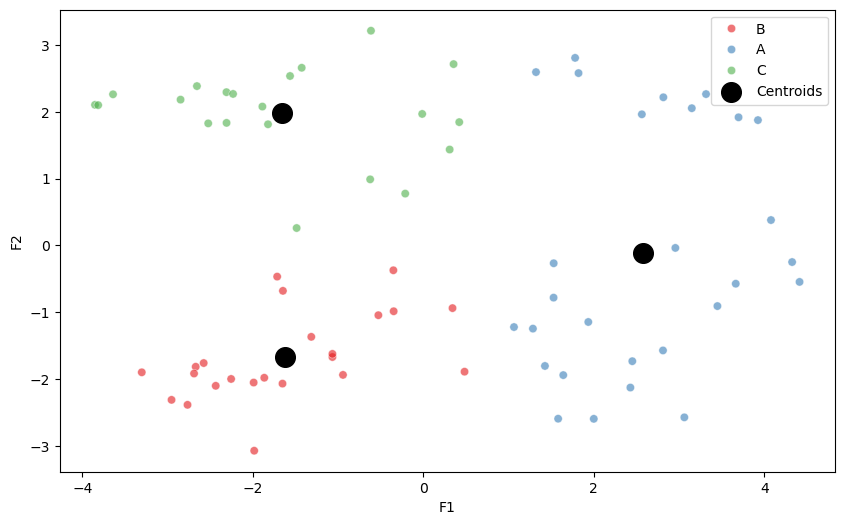

In [151]:
centroids = kmeans.cluster_centers_
centroids_proj = pca.transform(centroids)

plt.figure(figsize=(10,6))
sns.scatterplot(x=X_proj[:, 0],y= X_proj[:, 1], hue=labels, palette="Set1", alpha=0.6)

plt.scatter(centroids_proj[:, 0], centroids_proj[:, 1], c="black", marker="o", s=200, label="Centroids")

plt.xlabel("F1")
plt.ylabel("F2")
plt.legend()

In [152]:
X_df["cluster"].value_counts()

cluster
A    28
B    23
C    21
Name: count, dtype: int64

Ajout de la colonne cluster dans le dataset

In [153]:
df["cluster"] = X_df["cluster"]

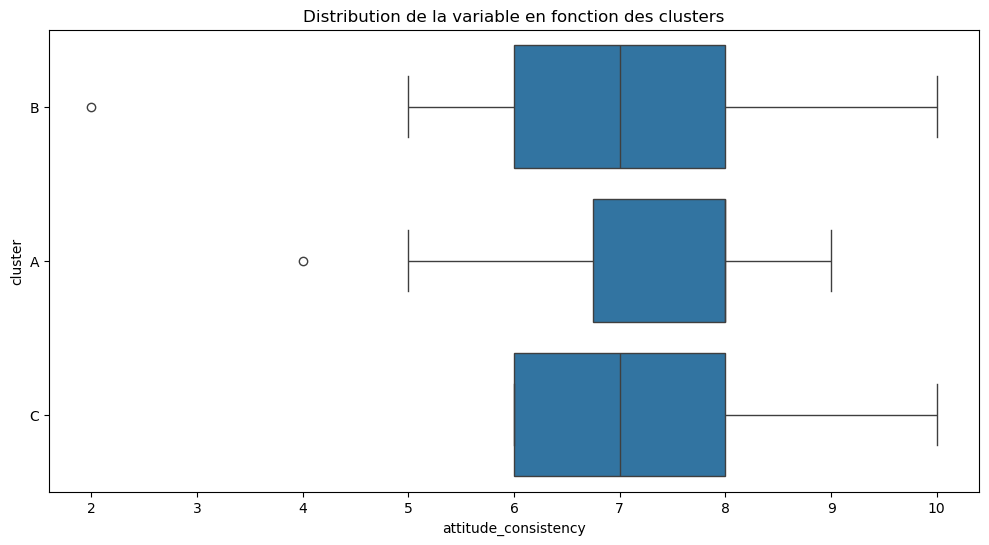

In [154]:
plt.figure(figsize=(12, 6))
sns.boxplot(x=df["attitude_consistency"], y=df["cluster"], data=df)
plt.title("Distribution de la variable en fonction des clusters")
plt.show()

In [155]:
df.groupby("cluster").mean().round(2)

,behavior_sexualRisk,behavior_eating,behavior_personalHygine,intention_aggregation,intention_commitment,attitude_consistency,attitude_spontaneity,norm_significantPerson,norm_fulfillment,perception_vulnerability,perception_severity,motivation_strength,motivation_willingness,socialSupport_emotionality,socialSupport_appreciation,socialSupport_instrumental,empowerment_knowledge,empowerment_abilities,empowerment_desires
cluster,,,,,,,,,,,,,,,,,,,
A,9.21,13.25,9.64,7.64,13.39,7.25,8.68,3.18,8.00,7.43,4.71,11.07,6.07,4.39,3.61,6.82,6.25,5.07,5.93
B,9.96,12.17,11.52,8.04,13.26,6.83,8.74,1.78,4.30,5.22,2.83,13.39,11.91,10.78,8.35,13.30,13.17,11.91,13.09
C,9.95,12.86,12.52,8.10,13.38,7.48,8.38,4.52,13.71,13.57,9.10,13.95,12.10,10.10,7.19,11.90,13.38,12.14,13.00


In [159]:
df["behavior_sexualRisk"].value_counts()

behavior_sexualRisk
10    64
8      2
7      2
9      2
2      1
6      1
Name: count, dtype: int64

In [160]:
df.query("cluster=='A'")

,behavior_sexualRisk,behavior_eating,behavior_personalHygine,intention_aggregation,intention_commitment,attitude_consistency,attitude_spontaneity,norm_significantPerson,norm_fulfillment,perception_vulnerability,perception_severity,motivation_strength,motivation_willingness,socialSupport_emotionality,socialSupport_appreciation,socialSupport_instrumental,empowerment_knowledge,empowerment_abilities,empowerment_desires,cluster
1,10,11,11,10,14,7,7,5,5,4,2,15,13,7,6,5,5,4,4,A
2,10,15,3,2,14,8,10,1,4,7,2,7,3,3,6,11,3,3,15,A
3,10,11,10,10,15,7,7,1,5,4,2,15,13,7,4,4,4,4,4,A
4,8,11,7,8,10,7,8,1,5,3,2,15,5,3,6,12,5,4,7,A
5,10,14,8,6,15,8,10,1,3,4,2,14,8,7,2,7,13,9,6,A
6,10,15,4,6,14,6,10,5,3,7,2,7,13,3,3,15,3,3,5,A
7,8,12,9,10,10,5,10,5,5,5,2,10,9,13,2,9,8,7,12,A
9,7,15,7,6,11,8,8,5,3,3,4,15,3,8,2,9,3,4,4,A
10,7,15,7,10,14,7,9,1,3,8,2,4,3,7,9,13,8,3,9,A
11,10,15,8,9,15,7,10,1,3,7,2,15,3,3,6,13,7,5,9,A
